---
title: Population-weighted aggregation
short_title: Population weighting
---

When aggregating gridded climate data to administrative regions, a simple spatial average can be misleading if population is unevenly distributed across the region. Population weighting provides a more accurate measure of the conditions experienced by people, which is particularly important for health-related analyses.

## Why use population weighting?

Consider a region where most people live in urban areas concentrated in one part of the territory, while the rest is sparsely populated. An unweighted spatial average would give equal importance to all grid cells, regardless of whether people actually live there. This means the resulting average may not accurately represent the conditions experienced by the typical person in that region.

**Population weighting solves this problem** by giving more weight to grid cells where more people live. This ensures that the aggregated climate values better reflect the actual exposure of the population.

Population-weighted aggregation is especially valuable when:
- Analyzing health impacts of climate and environmental conditions
- Population is concentrated in specific areas (cities, valleys, coastal zones)  
- The measured condition varies significantly across the region
- Results will inform public health decisions or interventions

## The population weighting method

The basic formula for population-weighted aggregation is:

$$
\text{Weighted Average} = \frac{\sum (\text{Variable} \times \text{Population})}{\sum \text{Population}}
$$

In practice, this means:
1. **Align** climate and population data to the same grid
2. **Multiply** each grid cell varaible by the corresponding population count
3. **Sum** these weighted values across the region
4. **Divide** by the total population of the region

In this tutorial, we'll demonstrate this workflow using PM2.5 air quality data and population data for two districts in Sri Lanka.

## Import required libraries

We'll use several Python libraries for this analysis:
- **xarray**: For working with multi-dimensional climate data
- **geopandas**: For handling geographic boundaries
- **earthkit.transform**: For spatial aggregation functions
- **numpy**: For numerical operations

In [38]:
import xarray as xr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from earthkit.transforms import spatial

## Load PM2.5 air quality data

We start by loading daily PM2.5 (particulate matter) air quality data for Sri Lanka from December 2022 through January 2023. To keep the dataset lightweight, it has been spatially restricted to the Colombo and Kalutara districts rather than the full country. Please note that the data is only included to demonstrate the population weighting method, and should be not be used to analyse PM2.5 levels. 

This NetCDF file contains gridded PM2.5 concentration values across space and time:

In [39]:
file = "../data/pm25-sri-lanka-colombo-kalutara-dec-2022-jan-2023.nc"
pm_data = xr.open_dataset(file)
pm_data

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 62, lat: 70, lon: 60)
Coordinates:
  * time     (time) datetime64[ns] 496B 2022-12-01 2022-12-02 ... 2023-01-31
  * lat      (lat) float32 280B 6.305 6.315 6.325 6.335 ... 6.975 6.985 6.995
  * lon      (lon) float32 240B 79.81 79.82 79.82 79.83 ... 80.38 80.39 80.39
Data variables:
    pm25     (time, lat, lon) float64 2MB ...

To look at the data, we can select the last day available (31 January 2023) and the PM2.5 variable. The plot shows the highest PM2.5 concentrations in the north-west region (around Colombo), and the lowest values are in the eastern region away from the coast. 

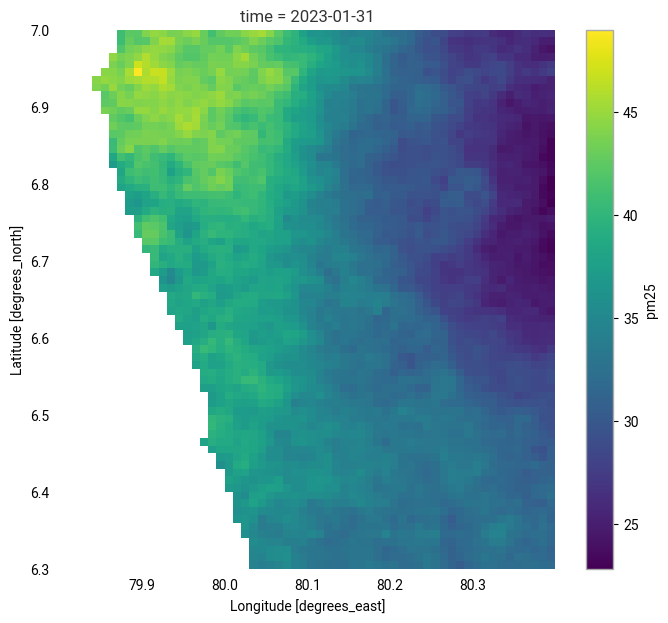

In [40]:
pm_data.isel(time=-1).pm25.plot()


## Load district boundaries

Next, we load the geographic boundaries for the two districts covered by the PM2.5 dataset, Colombo and Kalutara:

In [41]:
districts_file = "../data/sri-lanka-districts-colombo-kalutara.geojson"
districts = gpd.read_file(districts_file)
districts

,name,code,geometry
0,Colombo,LK11,"MULTIPOLYGON (((80.1793 6.97758, 80.17885 6.97..."
1,Kalutara,LK13,"MULTIPOLYGON (((80.1777 6.81586, 80.17769 6.81..."


The districts were downloaded from [Humanitarian Data Exchange (HDX)](https://data.humdata.org/dataset/cod-ab-lka). We can plot the two districts (Colombo north and Kalutara south): 

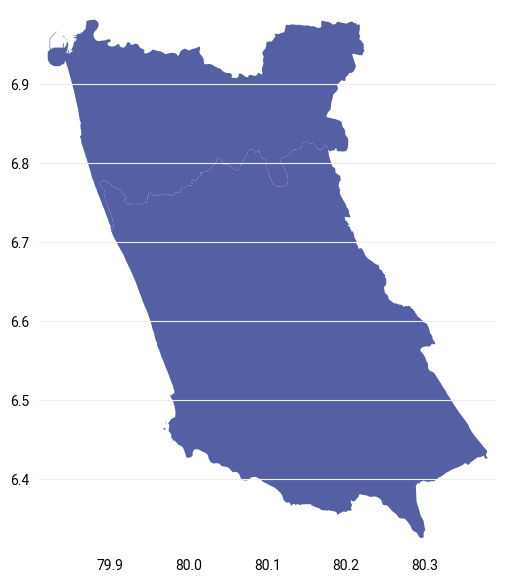

In [42]:
districts.plot();

## Select data for one year

For this example, we'll focus on PM2.5 data from 2023. We can easily filter the dataset by year using xarray's datetime indexing:

In [43]:
pm_data_2023 = pm_data.sel(time=pm_data['time'].dt.year == 2023)
pm_data_2023

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 31, lat: 70, lon: 60)
Coordinates:
  * time     (time) datetime64[ns] 248B 2023-01-01 2023-01-02 ... 2023-01-31
  * lat      (lat) float32 280B 6.305 6.315 6.325 6.335 ... 6.975 6.985 6.995
  * lon      (lon) float32 240B 79.81 79.82 79.82 79.83 ... 80.38 80.39 80.39
Data variables:
    pm25     (time, lat, lon) float64 1MB ...

## Load population data

Now we load the population raster for Sri Lanka. This file contains population counts per grid cell at approximately 1 km resolution. Note that we rename the coordinate dimensions to match our PM2.5 data (`lon` and `lat`):

In [44]:
pop_file = "../data/lka_pop_2023_CN_1km_R2025A_UA_v1.tif"
pop_ds = xr.open_dataset(pop_file)
pop_data = pop_ds['band_data'].rename({"x": "lon", "y": "lat"})
pop_data

<xarray.DataArray 'band_data' (band: 1, lat: 471, lon: 284)> Size: 535kB
[133764 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * lon          (lon) float64 2kB 79.52 79.53 79.54 79.55 ... 81.86 81.87 81.88
  * lat          (lat) float64 4kB 9.838 9.829 9.821 9.813 ... 5.938 5.929 5.921
    spatial_ref  int64 8B ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      global_pop_2023_CN_1km_R2025A_v1

If we plot the data we see areas of the country with no poulation, and the higest population density seems to be in the western part around Colombo. Please note that the data is displayed using a regular latitude/longitude grid, and not using a map projection. 

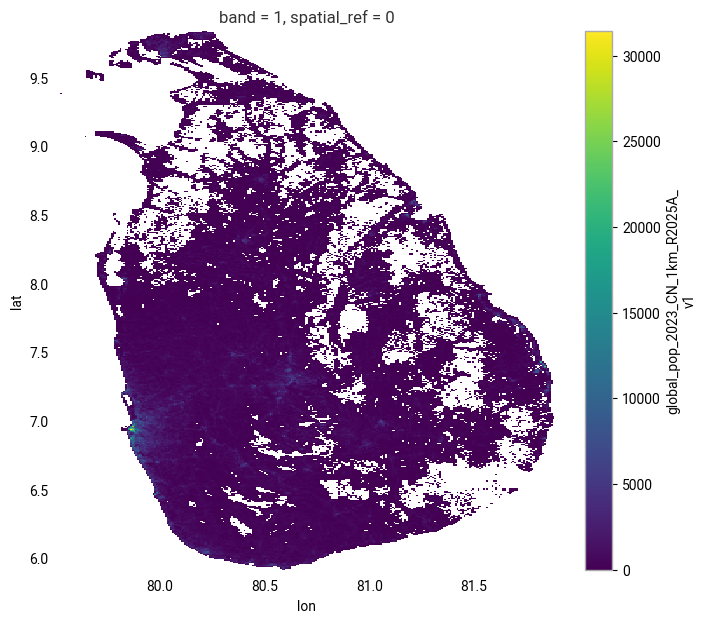

In [45]:
pop_data.plot()

## Align population data to climate grid

**Critical step**: The population and PM2.5 data have different grid alignments. We need to resample the population data to match the PM2.5 grid exactly. We use nearest-neighbor interpolation to preserve population counts:

In [46]:
pop_aligned = pop_data.interp(lon=pm_data_2023.lon, lat=pm_data_2023.lat, method="nearest")

## Calculate weighted PM2.5 values

Now we multiply each PM2.5 value by the corresponding population count. This gives us the "population-weighted PM2.5" for each grid cell:

In [47]:
pm_weighted = pm_data_2023 * pop_aligned

If we plot the result we see some white areas with no population and the PM2.5 values are removed. The values of other grid cells should reflect the estimated population for the same area, giving a higher prominence to areas where both PM2.5 concentration and population is high. 

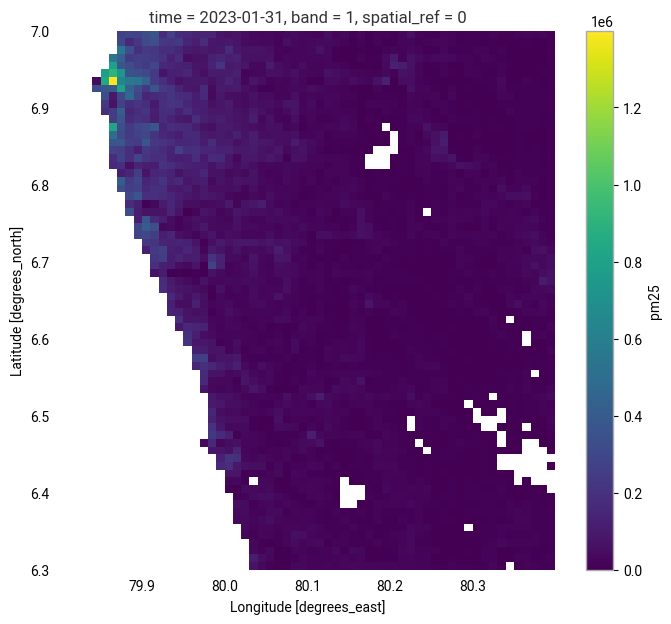

In [48]:
pm_weighted.isel(time=-1).pm25.plot()

## Aggregate to districts

Finally, we complete the population-weighted aggregation:

1. **Sum weighted PM2.5** (numerator): Total of all PM2.5 × population values within each district
2. **Sum population** (denominator): Total population within each district  
3. **Divide**: This gives us the population-weighted average PM2.5 for each district

We use earthkit's `spatial.reduce` function to perform spatial aggregation for each district polygon:

In [49]:
agg_num = spatial.reduce(pm_weighted, districts, how="sum", mask_dim="code")
agg_den = spatial.reduce(pop_aligned, districts, how="sum", mask_dim="code")

pw = agg_num / agg_den

pw = pw.rename({"pm25": "pm25_popweighted"})

agg_df = pw.to_dataframe().reset_index().drop(columns=['band', 'spatial_ref'])
agg_df

,time,code,pm25_popweighted
0,2023-01-01,LK11,43.924891
1,2023-01-01,LK13,38.645365
2,2023-01-02,LK11,45.822828
3,2023-01-02,LK13,35.279168
4,2023-01-03,LK11,33.905775
...,...,...,...
57,2023-01-29,LK13,57.848309
58,2023-01-30,LK11,47.405954
59,2023-01-30,LK13,39.707348
60,2023-01-31,LK11,41.998945


The resulting dataframe shows population-weighted PM2.5 values for each district and time period. These values represent the average PM2.5 exposure experienced by people in each district, accounting for where people actually live.

## Processing multiple years

If you have data spanning multiple years, you'll want to use the appropriate population dataset for each year, since population distributions change over time. Here's an example that loops through multiple years:

In [10]:
years = np.unique(pm_data['time'].dt.year).astype(str)

for year in years:
    print(f"Calculating {year}")
    pm_year = pm_data.sel(time=year)

    pop_file = f"../data/lka_pop_{year}_CN_1km_R2025A_UA_v1.tif"
    pop_ds = xr.open_dataset(pop_file)
    pop_data = pop_ds['band_data'].rename({"x": "lon", "y": "lat"})
    pop_aligned = pop_data.interp(lon=pm_year.lon, lat=pm_year.lat, method="nearest")

    pm_weighted = pm_year * pop_aligned

    agg_num = spatial.reduce(pm_weighted, districts, how="sum", mask_dim="code")
    agg_den = spatial.reduce(pop_aligned, districts, how="sum", mask_dim="code")

    pw = agg_num / agg_den
    pw = pw.rename({"pm25": "pm25_popweighted"})

    agg_df = pw.to_dataframe().reset_index().drop(columns=['band', 'spatial_ref'])
    print(agg_df)

Calculating 2022
         time  code  pm25_popweighted
0  2022-12-01  LK11         32.523187
1  2022-12-01  LK13         31.651156
2  2022-12-02  LK11         36.380375
3  2022-12-02  LK13         32.709560
4  2022-12-03  LK11         26.958593
..        ...   ...               ...
57 2022-12-29  LK13         36.403322
58 2022-12-30  LK11         33.888856
59 2022-12-30  LK13         37.663193
60 2022-12-31  LK11         29.629065
61 2022-12-31  LK13         28.865093

[62 rows x 3 columns]
Calculating 2023
         time  code  pm25_popweighted
0  2023-01-01  LK11         43.924891
1  2023-01-01  LK13         38.645365
2  2023-01-02  LK11         45.822828
3  2023-01-02  LK13         35.279168
4  2023-01-03  LK11         33.905775
..        ...   ...               ...
57 2023-01-29  LK13         57.848309
58 2023-01-30  LK11         47.405954
59 2023-01-30  LK13         39.707348
60 2023-01-31  LK11         41.998945
61 2023-01-31  LK13         36.978532

[62 rows x 3 columns]
